# Problem statement

The Stokes problem is a classical example of a mixed problem.

# Initialize

In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from spfem.geometry import GeometryMeshPyTriangle
%matplotlib inline

# Geometry and mesh generation

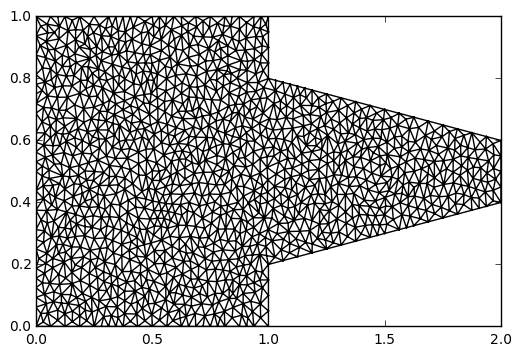

In [2]:
g = GeometryMeshPyTriangle(np.array([(0, 0), (1, 0), (1, 0.2), (2, 0.4), (2, 0.6), (1, 0.8), (1, 1), (0, 1)]))
m = g.mesh(0.03)
m.draw()
m.show()

# Assembly

In [3]:
from spfem.element import ElementTriP1, ElementTriP2, ElementH1Vec
from spfem.assembly import AssemblerElement

Next we create assemblers for the elements. We can give different elements for the solution vector and the test function. In this case we form the blocks $A$ and $B$ separately.

In [4]:
a = AssemblerElement(m, ElementH1Vec(ElementTriP2()))
b = AssemblerElement(m, ElementH1Vec(ElementTriP2()), ElementTriP1())
c = AssemblerElement(m, ElementTriP1())

In [5]:
def stokes_bilinear_a(du, dv):
    def inner_product(a, b):
        return a[0][0]*b[0][0] +\
               a[0][1]*b[0][1] +\
               a[1][0]*b[1][0] +\
               a[1][1]*b[1][1]
    def eps(dw): # symmetric part of the velocity gradient
        import copy
        dW = copy.deepcopy(dw)
        dW[0][1] = .5*(dw[0][1] + dw[1][0])
        dW[1][0] = dW[0][1]
        return dW
    return inner_product(eps(du), eps(dv))

A = a.iasm(stokes_bilinear_a) # iasm takes a function handle defining the weak form

In [6]:
def stokes_bilinear_b(du, v):
    return (du[0][0]+du[1][1])*v

B = b.iasm(stokes_bilinear_b)

In [14]:
from spfem.utils import stack
from scipy.sparse import csr_matrix
eps = 1e-1
C = c.iasm(lambda u, v: u*v)
K = stack(np.array([[A, B.T], [B, -eps*C]])).tocsr()

In [15]:
from spfem.utils import direct
import copy
x = np.zeros(K.shape[0])
f = copy.deepcopy(x)

# find DOF sets manually. some helper functions for this are planned in the future
dirichlet_nodes = np.intersect1d(m.boundary_nodes(), m.nodes_satisfying(lambda x,y: x >= 1.0))
dirichlet_facets = np.intersect1d(m.boundary_facets(), m.facets_satisfying(lambda x,y: x >= 1.0))
inflow_nodes = np.intersect1d(m.boundary_nodes(), m.nodes_satisfying(lambda x,y: x == 2.0))
inflow_facets = np.intersect1d(m.boundary_facets(), m.facets_satisfying(lambda x,y: x == 2.0))
dirichlet_dofs = a.dofnum_u.getdofs(N=dirichlet_nodes, F=dirichlet_facets)
inflow_dofs = a.dofnum_u.getdofs(N=inflow_nodes, F=inflow_facets)

# set inflow condition and solve
x[inflow_dofs] = -1.0
I = np.setdiff1d(np.arange(K.shape[0]), dirichlet_dofs)
x = direct(K, f, x=x, I=I)

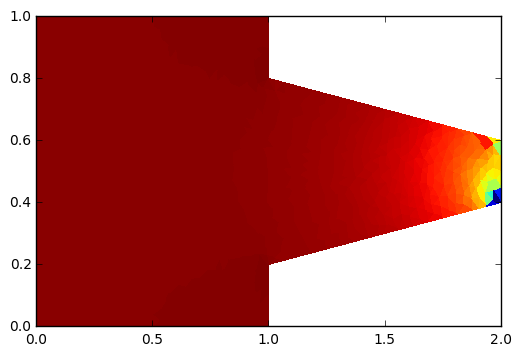

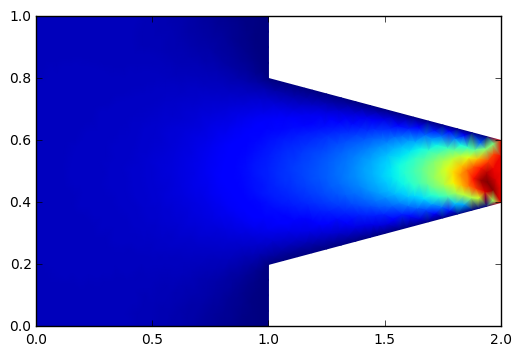

In [18]:
m.plot(x[np.arange(C.shape[0]) + A.shape[0]])
m.plot(np.sqrt(x[a.dofnum_u.n_dof[0, :]]**2+x[a.dofnum_u.n_dof[0, :]]**2), smooth=True)
m.show()